In [1]:
merging_datasets <- c("SCIA", "ISAC")
state <- "Valle D'Aosta"
match_dist <- 15000
new_dataset <- "VDA"

In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, "Valle D''Aosta", "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
metadata <- query_checkpoint_meta(merging_datasets, "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 100), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!(state %in% c("Piemonte"))) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", "vda", "raw_analysis.xlsx"))


In [22]:
source("notebooks/ds_regionali/vda/procedures/match_taggers.R")
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(require_all = TRUE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", "vda", "tagged_analysis.xlsx"), starts_with("tag_"))


In [23]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
# Dealing with ISAC series
ranked_series_groups <- rank_series_groups(
    gs$table,
    metadata |> mutate(network_prio = if_else(network == "ISAC", 2L, 1L)),
    c("SCIA", "ISAC"),
    desc(network_prio), desc(dataset), desc(sensor_last)
)
ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 20L, 0.5, ignore_corrections, contribution_threshold = 365L * 2L)


In [24]:
i <- incomp |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i

pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,dataset_x,sensor_key_x,name_y,dataset_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
2,0.6523456,-0.06003758,0.1183109,-0.0546491,2,84,3,1,1,Ayas - Alpe Courthoud,SCIA,255,AYAS_ALPE_COURTHOUD,ISAC,223


In [25]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 100, ignore_corrections, contribution_threshold = -1L)
db <- merged_checkpoint(merge_results, metadata, new_dataset, conns$stations, gs$table)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2489384,133.0,3684844,196.8,NA,3684844,196.8
Vcells,23252697,177.5,70642674,539.0,16384,91875186,701.0


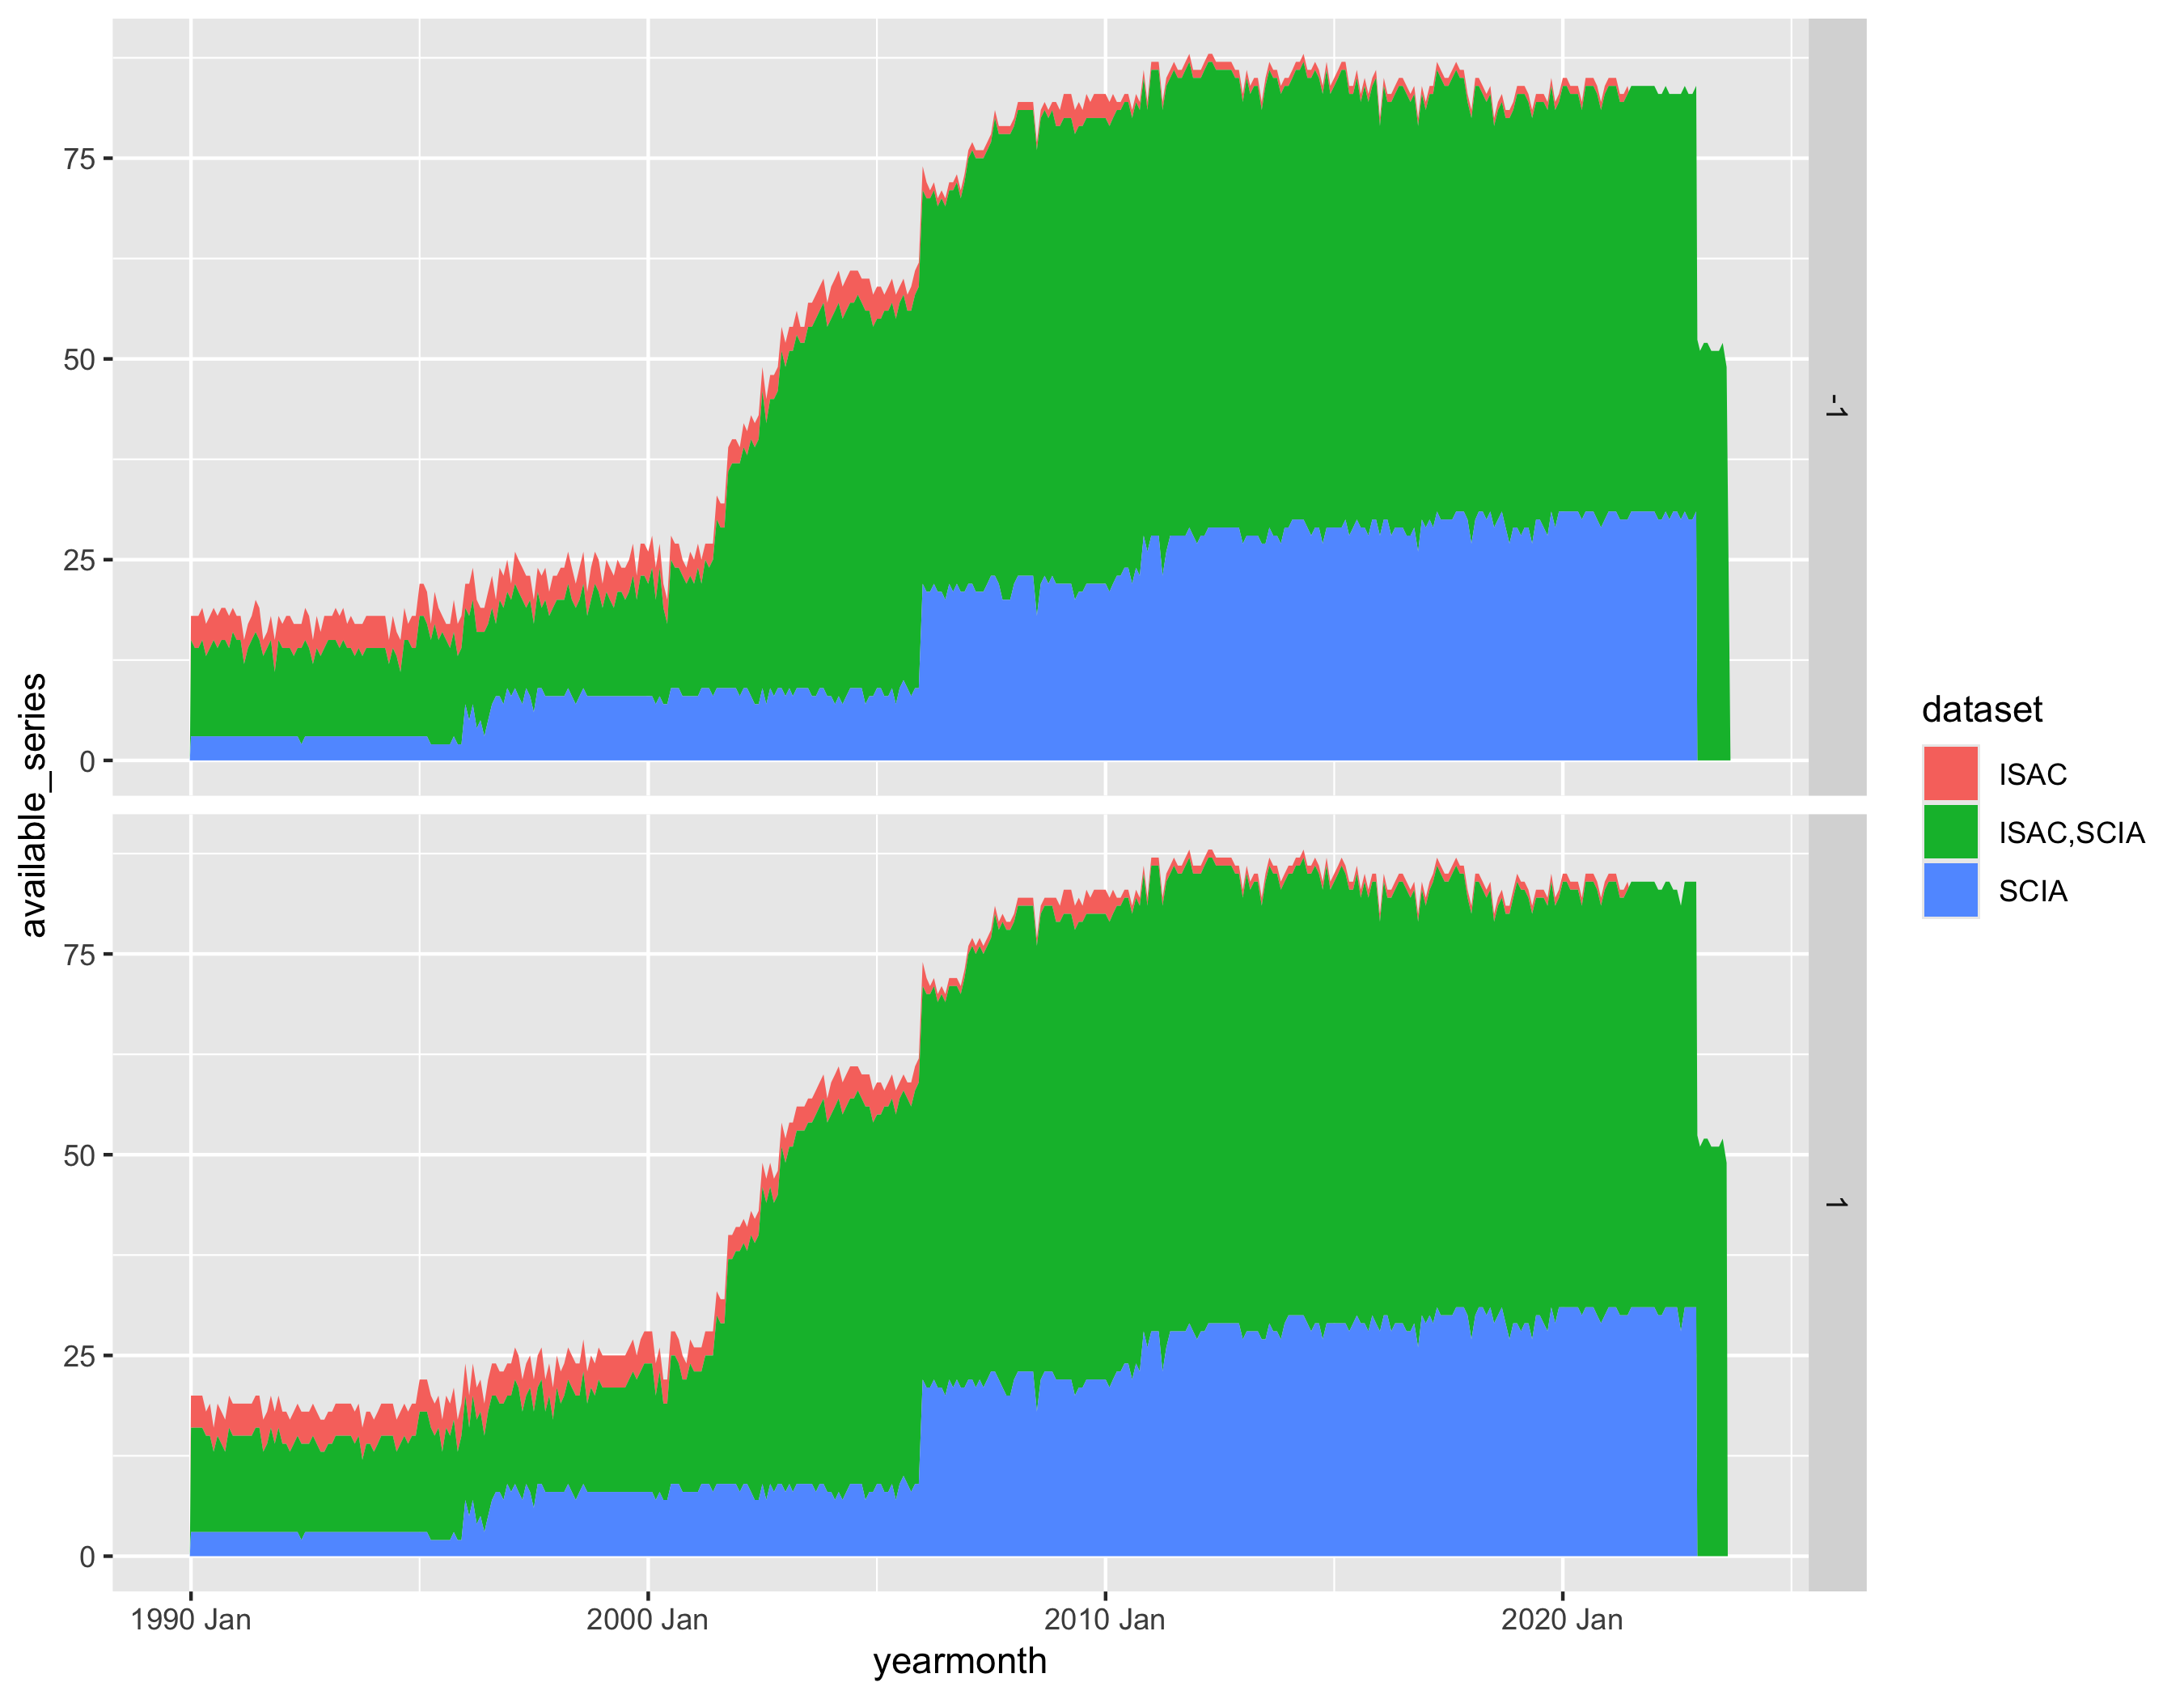

In [26]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |> select(sensor_key, from_datasets) |> collect() |> rowwise() |> mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |> ungroup() |> select(-from_datasets)
dt <- db$data |> select(-dataset) |> left_join(mt, by = "sensor_key", copy = TRUE) |> filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)

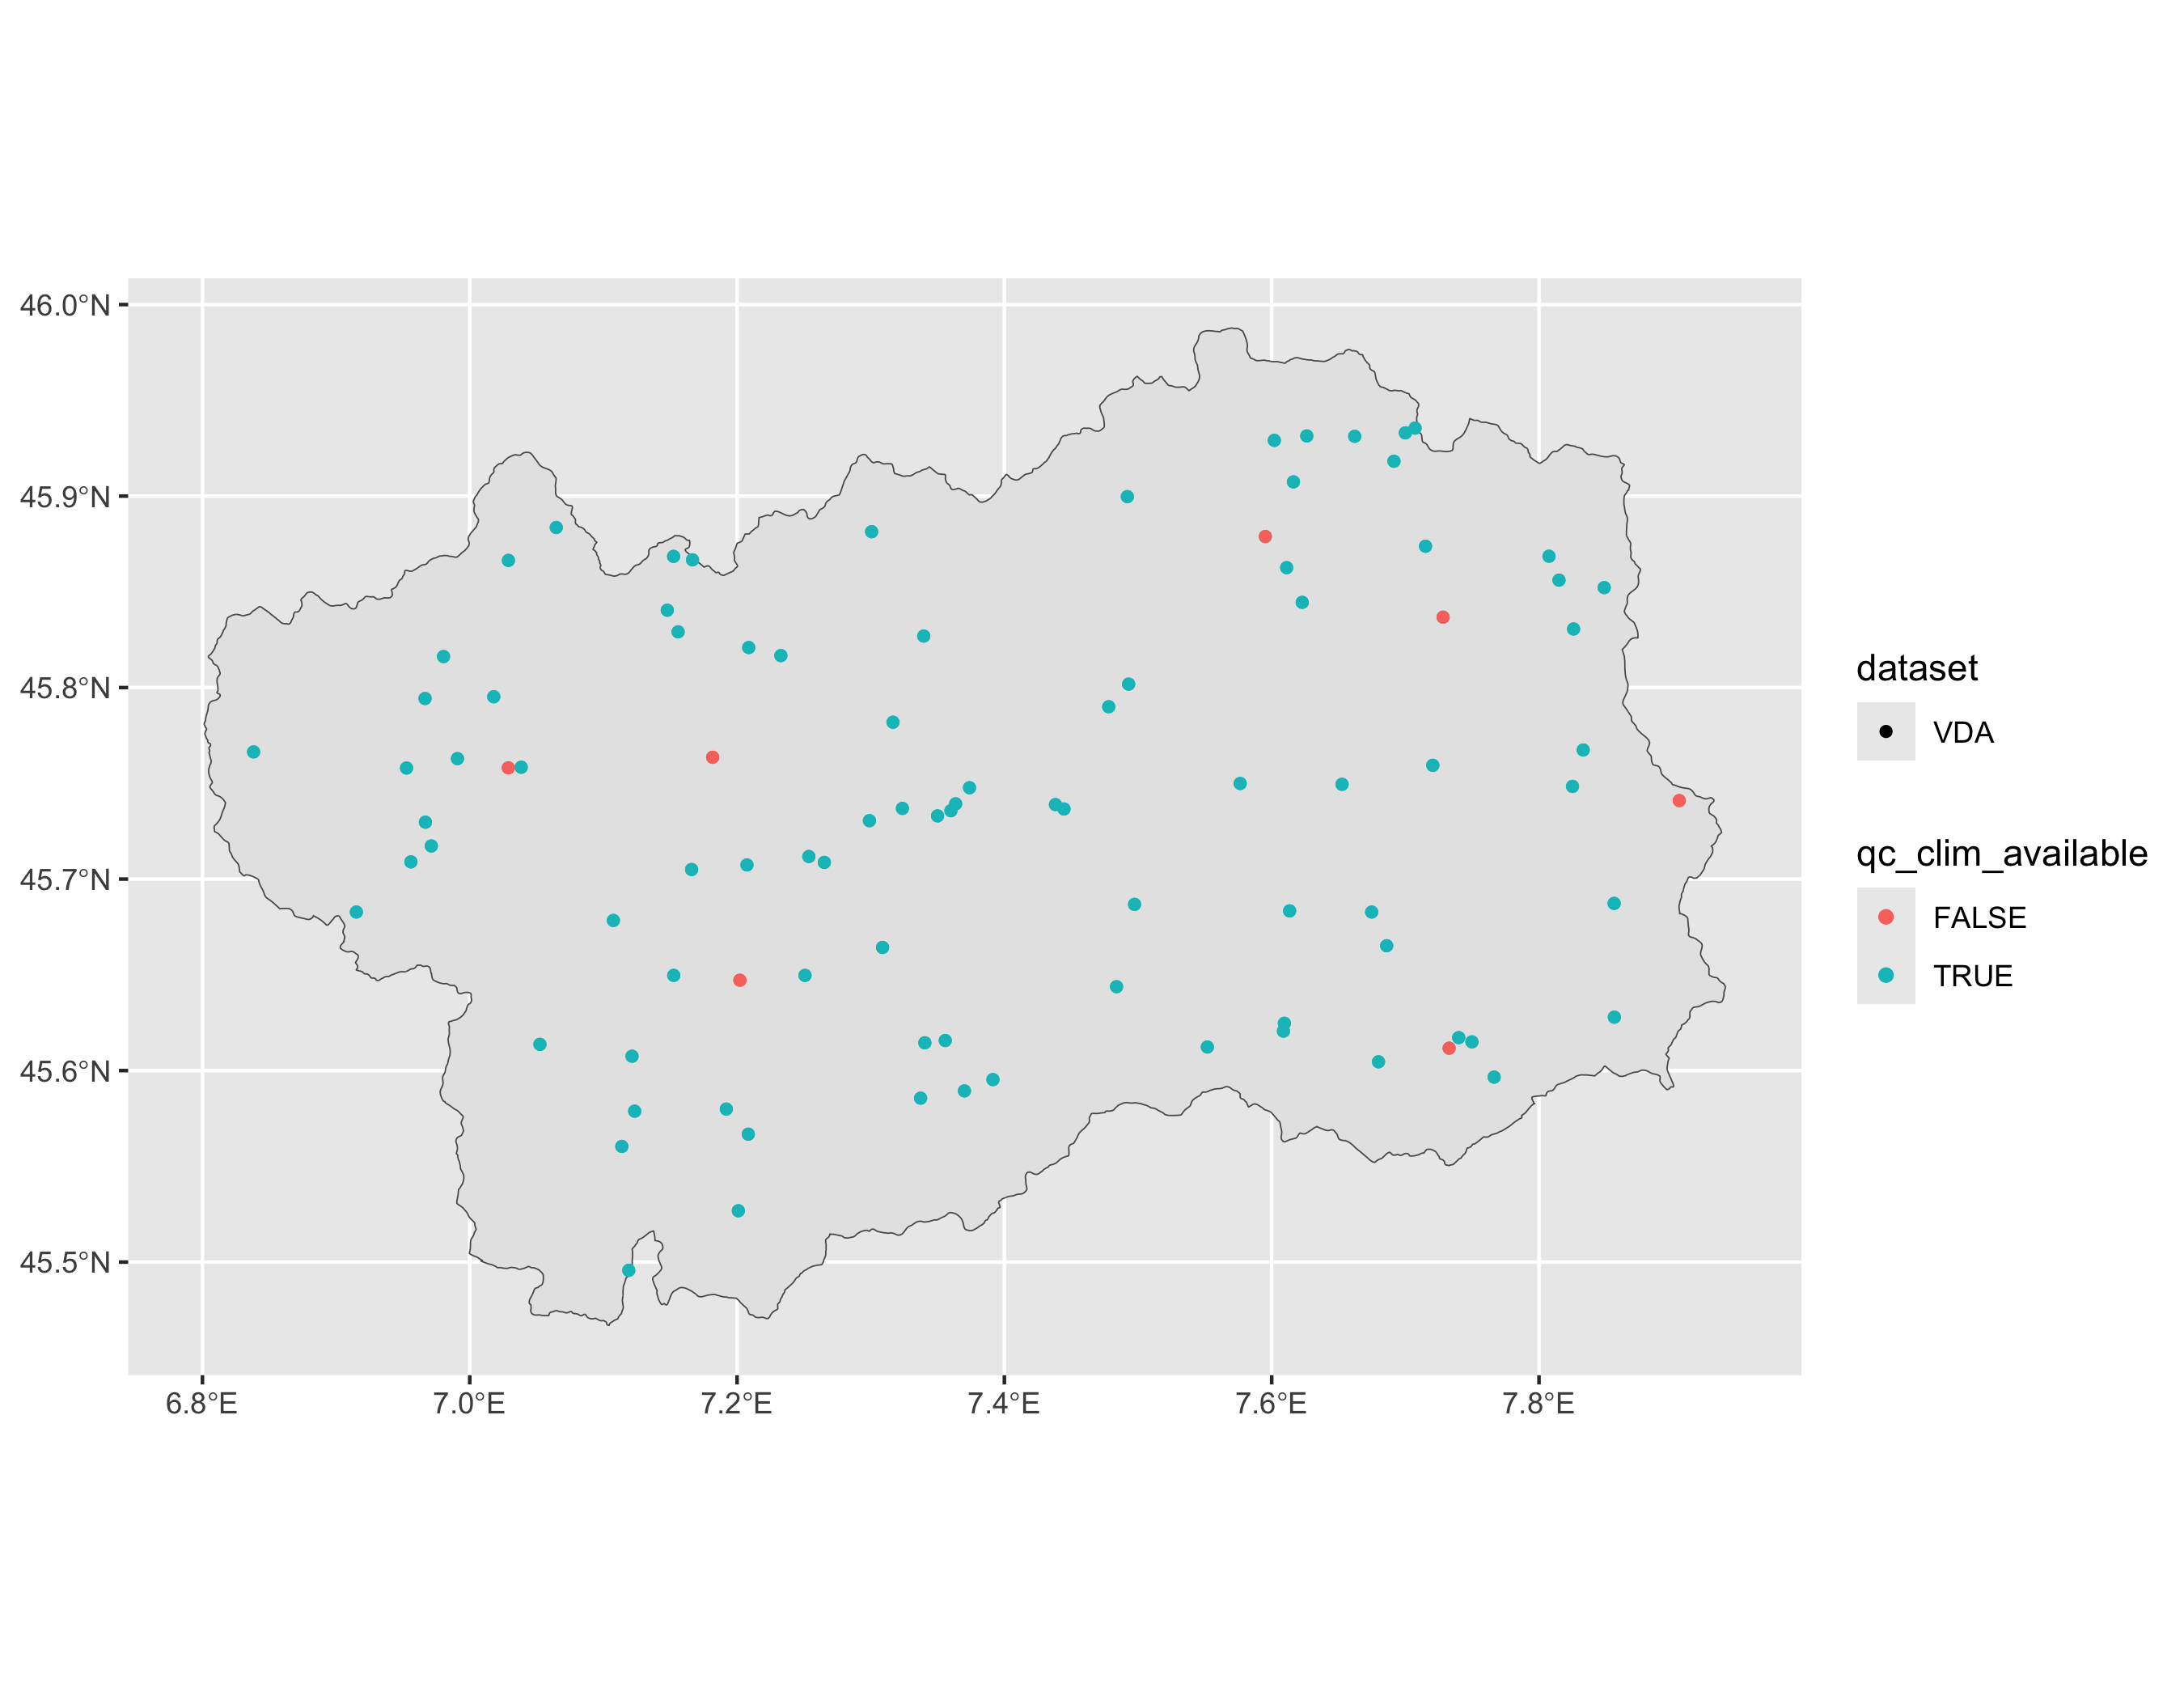

In [27]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries)
pd$plot 

Warning message:
"Removed 28 rows containing non-finite values (`stat_bin()`)."


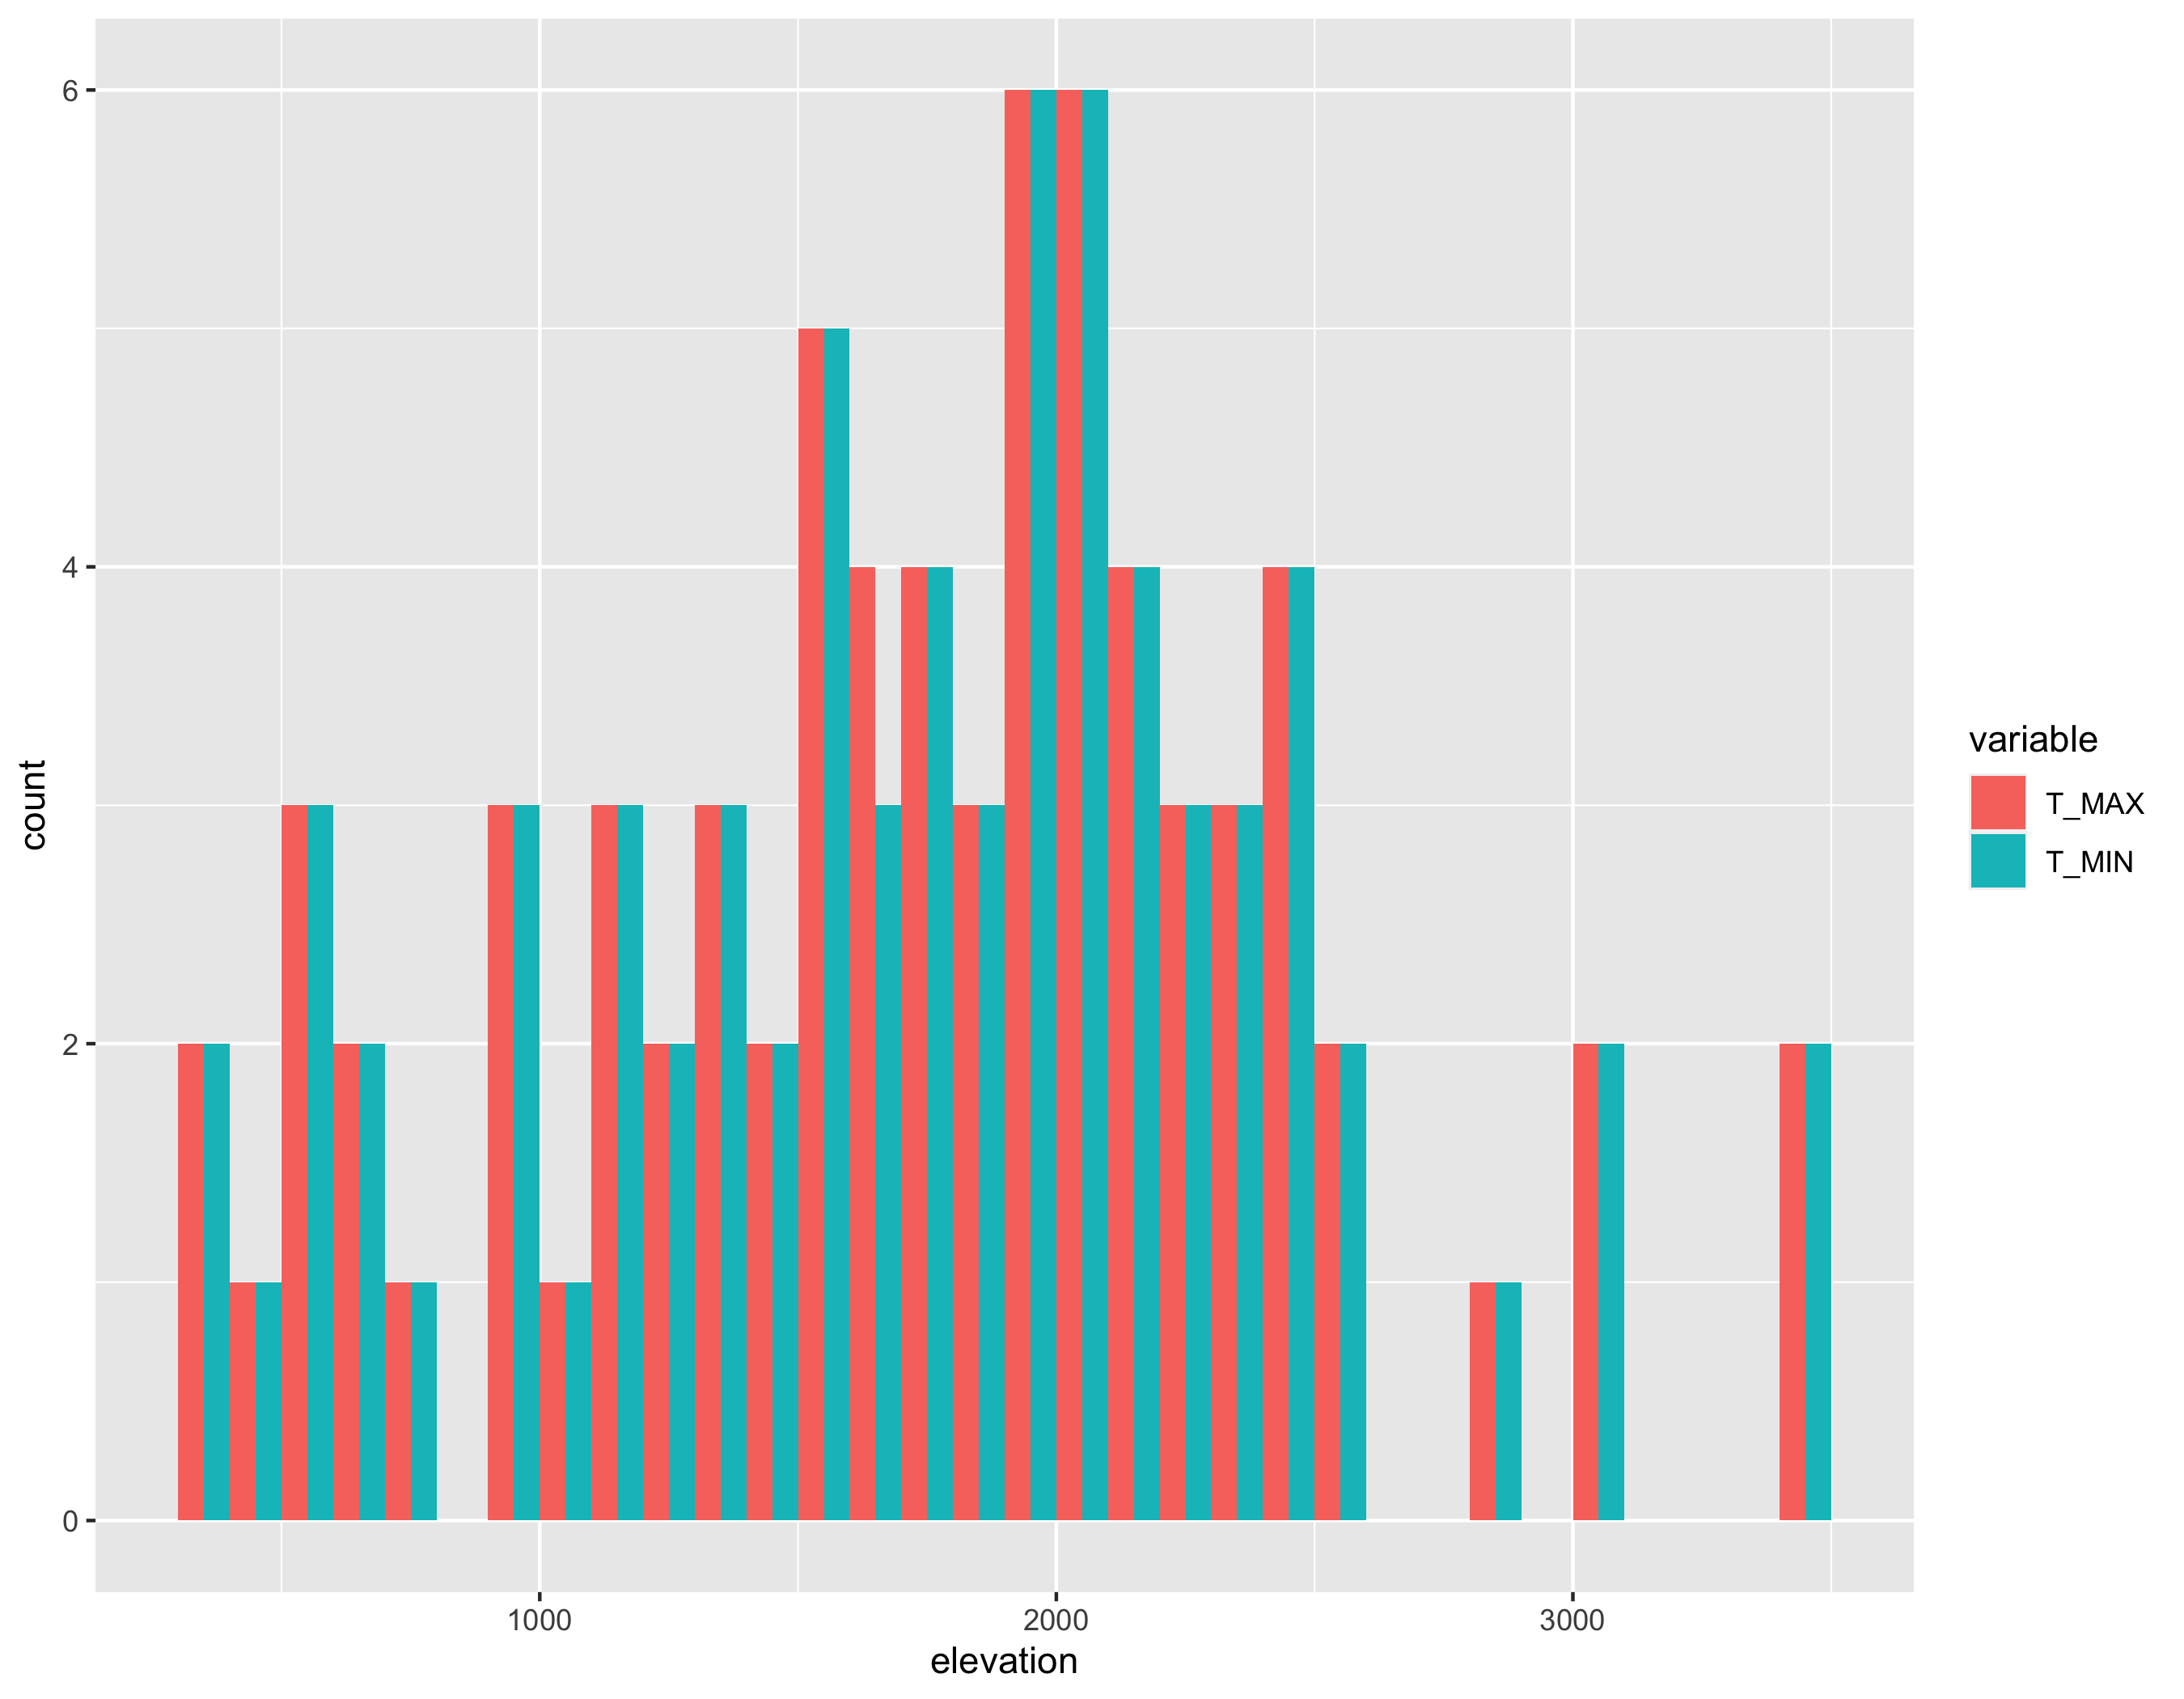

In [18]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())